## STXM - MISTRIAL

In [1]:
import sys
from pathlib import Path

import hyperspy.api as hs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from dxchange import reader
from matplotlib import gridspec, ticker
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, to_rgba

In [2]:
# Ensure custom module path is set before import
sys.path.append(r"D:\CHENG\OneDrive - UAB\ICMAB-Python\Figure")
from colors import tol_cmap, tol_cset  # type: ignore

# 画图的初始设置
plt.style.use(r"D:\CHENG\OneDrive - UAB\ICMAB-Python\Figure\liuchzzyy.mplstyle")
# print(plt.style.available)  # noqa: ERA001

# xarray setting
xr.set_options(
    cmap_sequential="viridis",
    cmap_divergent="viridis",
    display_width=150,
)  # viridis, gray

# 颜色设定
colors = list(tol_cset("vibrant"))
if r"sunset" not in plt.colormaps():
    plt.colormaps.register(tol_cmap("sunset"))
if r"rainbow_PuRd" not in plt.colormaps():
    plt.colormaps.register(tol_cmap("rainbow_PuRd"))  # 备用 plasma

# 输出的文件夹
path_out = Path(r"C:\Users\chengliu\Desktop\Figure")

### MnOOH

In [4]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


def add_sizebar(ax, size, bardata, color, barunits=None):
    if isinstance(bardata, float):
        if not isinstance(barunits, str):
            raise ValueError("barunits must be provided if bardata is a float.")
        asb = AnchoredSizeBar(
            ax.transData,
            size / bardata,
            "{} {}".format(size, barunits),
            loc="lower left",
            pad=0.1,
            borderpad=0.5,
            sep=1,
            frameon=False,
            color=color,
            label_top=True,
            fontproperties={"size": 9},
        )
        ax.add_artist(asb)
    else:
        if len(bardata.axes_manager.navigation_shape) == 2:
            barsize = bardata.axes_manager.navigation_axes[0].scale
            unit = bardata.axes_manager.navigation_axes[0].units
        elif len(bardata.axes_manager.signal_shape) == 2:
            barsize = bardata.axes_manager.signal_axes[0].scale
            unit = bardata.axes_manager.signal_axes[0].units
        asb = AnchoredSizeBar(
            ax.transData,
            size / barsize,  # type: ignore
            "{} {}".format(size, unit),  # type: ignore
            loc="lower left",
            pad=0.1,
            borderpad=0.5,
            sep=1,
            frameon=False,
            color=color,
            label_top=True,
            fontproperties={"size": 9},
        )
        ax.add_artist(asb)
    return asb

### 读取原始数据

In [5]:
path_folder = Path(
    r"D:\CHENG\OneDrive - UAB\ICMAB-Data\Zn-Mn\Results\STXM\ExSitu\MnOOH\Pristine\F8 MnOOH\Data"
)
path_file = path_folder.joinpath(r"20230701_F6Mn_245.2x1203.3y_specnorm.hdf5")

# Read the keys to find dataset, data_key is a list shown as below
data_key = reader.read_hdf_meta(path_file, add_shape=True)
display(data_key)

# Read all needed dataset via keys
data_unalignment = reader.read_hdf5(path_file, dataset=r"SpecNormalized/spectroscopy_normalized", shared=False)
energy = reader.read_hdf5(path_file, dataset=r"SpecNormalized/energy", shared=False)
data_x_pixel_size = reader.read_hdf5(path_file, dataset=r"SpecNormalized/x_pixel_size", shared=False)
data_y_pixel_size = reader.read_hdf5(path_file, dataset=r"SpecNormalized/y_pixel_size", shared=False)

(deque([' SpecNormalized',
        '    │',
        '    ├── Currents (228,)',
        '    ├── ExpTimes (228,)',
        '    ├── energy (228,)',
        '    ├── rotation_angle (228,)',
        '    ├── spectroscopy_normalized (228, 972, 982)',
        '    ├── x_pixel_size (1,)',
        '    └── y_pixel_size (1,)']),
 {'SpecNormalized_x_pixel_size': [0.013000000268220901, None],
  'SpecNormalized_y_pixel_size': [0.013000000268220901, None]})

In [7]:
# Bulid hyperspy object: a 2D image stack signal, and then plot it
from hyperspy.axes import DataAxis, UniformDataAxis

energy_axis = DataAxis(
    axis=energy,
    index_in_array=None,
    name="Energy",
    units="eV",
)
x_position = UniformDataAxis(
    offset=0, scale=data_x_pixel_size[0], size=data_unalignment.shape[2], name=r"x_position", units=r"um"
)
y_position = UniformDataAxis(
    offset=0, scale=data_y_pixel_size[0], size=data_unalignment.shape[1], name=r"y_position", units=r"um"
)
data_2d = hs.signals.Signal2D(data_unalignment, axes=[energy_axis, x_position, y_position])
data_2d

<Signal2D, title: , dimensions: (228|972, 982)>

#### 对 Energy Axis 进行插值修改

In [26]:
# # 对 Energy Axis 进行插值修改

# hs.set_log_level('ERROR')
# from hyperspy.axes import UniformDataAxis
# def interpolate_axis(data, energy, new_scale:float = 0.1, axis=0):
#     if r'Energy' in [axes.name for axes in data.axes_manager.navigation_axes]:
#         axis_new = UniformDataAxis(offset=energy[0], scale=new_scale, size=((energy.max() - energy.min())//new_scale+1), name="Energy", units='eV', navigate=True, is_binned=True)
#         data.interpolate_on_axis(axis_new, axis, inplace=True)
#     return data

# data_2d = interpolate_axis(data_2d, energy, new_scale=0.1, axis=0)
# data_2d.axes_manager

#### 数据对齐

In [ ]:
%matplotlib ipympl

shifts = data_2d.estimate_shift2D()
data_2d.align2D(
    shifts=shifts,
    show_progressbar=True,
)

s = data_2d.transpose(signal_axes=(0,), optimize=True).deepcopy()
s = -np.log(s)
s.plot()

  0%|          | 0/228 [00:00<?, ?it/s]

[########################################] | 100% Completed | 222.70 ms


In [ ]:
# # crop the region saturation
# s.crop(axis=1, start=0.0, end=8.7)

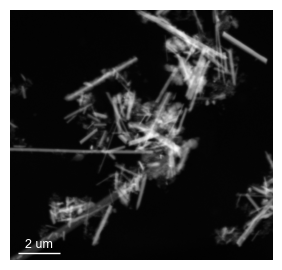

In [ ]:
# Th figure after alignment
%matplotlib inline
plt.close("all")
fig = plt.figure(figsize=(3.3, 2.5))
gs = gridspec.GridSpec(1, 1, width_ratios=None, height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position((0, 0, 1, 1))
ax.imshow(s.integrate1D(axis=-1).data, cmap="gray")
add_sizebar(ax, 2, s.integrate1D(axis=-1), "white")
ax.set_axis_off()
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)

plt.savefig(
    path.joinpath(path_out, r"1_sTXM_HADDF.tif"),
    pad_inches=0.05,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

In [ ]:
s.save(path.joinpath(path_out, r"1-data_aligned.hspy"), overwrite=True)

CPU times: total: 15.5 s
Wall time: 15.5 s


### PCA 降噪

In [ ]:
# PCA
s.decomposition(algorithm="SVD", navigation_mask=None, centre="signal")
# ps.plot_explained_variance_ratio(n=20, threshold=3, vline=True)
num_components = s.estimate_elbow_position()  # component number =  num_components + 1
# display(num_components)
# s.plot_decomposition_results()
# s.plot_decomposition_loadings(comp_ids=num_components+1, axes_decor="off", with_factors=True, per_row=(num_components+1)//2,)
# reconstruct data
ps_recon = s.get_decomposition_model(components=2 * (num_components + 1))
ps_recon.save(path.joinpath(path_out, r"1-data_pca.hspy"), overwrite=True)

%matplotlib ipympl
ps_recon.plot()

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=signal


CPU times: total: 3min 53s
Wall time: 44.5 s


### Mask 的选择，EELS Mappings 的方法

In [ ]:
# 定义元素特征峰能量范围（可扩展）
element_lines = {
    "O": (480.0, 600.0),  # O-K
    "Mn": (600.0, 700.0),  # Mn-L
    "Zn": (980.0, 1180.0),  # Zn-L
}

fit_ranges = {
    "O": (480.0, 520.0),  # O-K
    "Mn": (600.0, 623.0),  # Mn-L
    "Zn": (980.0, 1010.0),  # Zn-L
}

data_ranges = {
    "O": (480.0, 600.0),  # O-K
    "Mn": (600.0, 700.0),  # Mn-L
    "Zn": (980.0, 1280.0),  # Zn-L
}


def get_elements(data, element_lines: dict[str, tuple[float, float]]) -> tuple[str, ...]:
    """根据谱图能量范围，确定包含的元素。"""
    elements = tuple(
        element
        for element, (lowenergy, highenergy) in element_lines.items()
        if data.axes_manager["Energy"].high_value >= highenergy - 20
        and data.axes_manager["Energy"].low_value <= lowenergy + 20
    )
    return elements

In [ ]:
%matplotlib widget
roi_definitions = {
    "Mn": (651.0, 655.0),
    "Zn": (1025.0, 1165.0),
}

mask_ranges: dict[str, tuple[float, float] | None] = {
    "Mn": None,  # (6.0, 123.0),
    "Zn": None,  # (80.0, 148.0),
}

# 存放映射结果
ps_masks = {}
for element, (start, end) in roi_definitions.items():
    if element in results_rebgk.keys():
        if element == "all":
            ps_mappings[element] = None
        else:
            signal = results_rebgk[element]
            roi = hs.roi.SpanROI(start, end)
            _, map_img = hs.plot.plot_roi_map(signal, rois=[roi])
            if mask_ranges[element] is not None:
                ps_mappings[element] = map_img[0]
                mask = (ps_mappings[element] < mask_ranges[element][0]) | (
                    ps_mappings[element] > mask_ranges[element][1]
                )  # type: ignore
                ps_masks[element] = mask
                # ps_mappings[element].data[mask.data] = np.nan

            if mask_ranges[element] is None:
                q_min, q_max = np.nanpercentile(map_img[0].data, [0, 100])
                print(f"Element: {element}, Q_min: {q_min}, Q_max: {q_max}")
                ps_mappings[element] = map_img[0]
                mask = (ps_mappings[element] < q_min) | (ps_mappings[element] > q_max)
                ps_masks[element] = mask
                # ps_mappings[element].data[mask.data] = np.nan

            # 保存映射结果
            ps_mappings[element].save(path.joinpath(path_out, f"3-ps_{element}_mapping.hspy"), overwrite=True)
            ps_masks[element].save(path.joinpath(path_out, f"3-ps_{element}_mask.hspy"), overwrite=True)
    else:
        print(f"Element '{element}' not found. Skipping.")


# 关闭所有图窗口
plt.close("all")
element = "O"
# 创建一个横向的子图布局
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={"width_ratios": [2, 1]})  # type: ignore
element_mapping = ps_mappings.get(element).data  # type: ignore
element_mask = ps_masks.get(element).data  # type: ignore
file = np.where(element_mask, np.nan, element_mapping)  # type: ignore
# 画直方图
ax1.hist(file.flatten(), bins=30, color="steelblue", edgecolor="black")
# 去除上右边框
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
# 画灰度图像
im = ax2.imshow(file, cmap="Spectral", aspect=1.0)
ax2.axis("off")
ax2.set_title(f"{element} Mapping")
add_sizebar(ax2, 20, ps_mappings[element], "k")
# 自动紧凑布局
plt.tight_layout()
plt.show()

In [ ]:
mask_empty_vaule = [0.04, 0.5, 0.99]
ps_recon_sum = ps_recon.integrate1D(axis="Energy")
ps_recon_sum = ps_recon_sum / ps_recon_sum.nanmax().data[0]
mask_empty = (ps_recon_sum < mask_empty_vaule[0]) | (ps_recon_sum > mask_empty_vaule[2])
mask_empty.save(path.joinpath(path_out, r"2_mask_empty.hspy"), overwrite=True)

In [ ]:
# Empty filter
%matplotlib inline 
plt.close("all")
fig = plt.figure(figsize=(7, 2.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.set_box_aspect(0.8)

ax.plot(
    np.linspace(0, 1, ps_recon_sum.data.flatten().shape[0], endpoint=True),
    np.sort(ps_recon_sum.data.flatten()),
    color=colors[0],
)

ax.set_ylabel(
    r"Normalized Intensity (arb.u.)",
    fontsize=11,
)
ax.set_ylim(0.0, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.set_xlabel(
    r"Normalized Index (N)",
    fontsize=11,
)
ax.set_xlim(0.0, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.axhspan(ymin=0.0, ymax=mask_empty_vaule[0], alpha=0.3, zorder=2)
ax.axhspan(ymin=mask_empty_vaule[2], ymax=1.0, alpha=0.3, zorder=2)

# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0), ncols=1, frameon=False, fontsize=12, labelcolor='linecolor', columnspacing=0.4)
ax.text(
    0.65,
    0.9,
    f"{mask_empty_vaule[0], mask_empty_vaule[2]}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=11,
    c="k",
)
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=True,
    left=True,
    top=False,
    right=False,
    labelbottom=True,
    labelleft=True,
    labeltop=False,
    labelright=False,
)

# 图 B
subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([-0.1, 0.0, 1.0, 1.0])
ax.imshow(mask_empty.data, cmap="gray", aspect=1.0)
add_sizebar(ax, 2, mask_empty, "k")
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=False,
    left=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
)

plt.savefig(
    path.joinpath(path_out, r"2_300_sTXM_mask_empty.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, r"2_600_sTXM_mask_empty.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

#### 确定中间值

In [ ]:
def Bvalue(x, B, C):
    return -np.log((np.exp(-x * C) + B) / (1 + B))


def linear_model(x, m, b):
    return m * x + b


def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # 总体平方和
    return 1 - (ss_res / ss_tot)

In [ ]:
from tqdm.notebook import tqdm

sol = []
for k in tqdm(np.linspace(mask_empty_vaule[0] + 0.01, mask_empty_vaule[2], 100, endpoint=False)):
    try:
        mask_vaule = [mask_empty_vaule[0], k, mask_empty_vaule[2]]
        mask_thin = (ps_recon_sum >= mask_vaule[0]) & (ps_recon_sum <= mask_vaule[1])
        mask_thick = (ps_recon_sum > mask_vaule[1]) & (ps_recon_sum < mask_vaule[2])

        thick_1d = np.sort(np.nanmean(ps_recon.data[mask_thick.data], axis=0))
        thin_1d = np.sort(np.nanmean(ps_recon.data[mask_thin.data], axis=0))
        popt_mapping, pcov_mapping = scipy.optimize.curve_fit(
            Bvalue, xdata=thin_1d, ydata=thick_1d, method="trf", bounds=([0, -np.inf], [1, np.inf])
        )

        ps_recon_mapping = ps_recon.deepcopy()
        ps_recon_mapping.data = -np.log((1 + popt_mapping[0]) * np.exp(-ps_recon_mapping.data) - popt_mapping[0])
        mask_nan_mapping = np.isnan(ps_recon_mapping.mean(-1))
        thick_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thick.data], axis=0))
        thin_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thin.data], axis=0))

        popt_linear_mapping, pcov_linear_mapping = scipy.optimize.curve_fit(
            linear_model, xdata=thin_1d_b, ydata=thick_1d_b, method="lm"
        )
        r2 = calculate_r2(thick_1d_b, linear_model(thin_1d_b, *popt_linear_mapping))
        sol.append([k, popt_mapping, popt_linear_mapping, r2])
    except Exception as e:
        print(f"Error processing value {k}: {e}")
        continue  # 忽略错误继续循环

In [ ]:
sol = pd.DataFrame(sol)
print(
    sol.iloc[sol.iloc[:, 3].idxmax(), 0],
    sol.iloc[sol.iloc[:, 3].idxmax(), 1],
    sol.iloc[sol.iloc[:, 3].idxmax(), 2],
    sol.iloc[sol.iloc[:, 3].idxmax(), 3],
)
sol.to_csv(
    path.joinpath(path_out, r"2_Vaule_thin_thinck.csv"), sep=",", header=[r"k", r"popt_abs", r"popt_linear_abs", r"r2"]
)

#### 最后的结果

In [ ]:
mask_vaule = [mask_empty_vaule[0], sol.iloc[sol.iloc[:, 3].idxmax(), 0], mask_empty_vaule[2]]
mask_empty = (ps_recon_sum < mask_vaule[0]) | (ps_recon_sum > mask_vaule[2])
mask_thin = (ps_recon_sum >= mask_vaule[0]) & (ps_recon_sum <= mask_vaule[1])
mask_thick = (ps_recon_sum > mask_vaule[1]) & (ps_recon_sum < mask_vaule[2])

In [ ]:
# Empty filter
%matplotlib inline 
plt.close("all")
fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(
    np.linspace(0, 1, ps_recon_sum.data.flatten().shape[0], endpoint=True),
    np.sort(ps_recon_sum.data.flatten()),
    color=colors[0],
)

ax.set_ylabel(
    r"Normalized Intensity (arb.u.)",
    fontsize=11,
)
ax.set_ylim(0.0, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.set_xlabel(
    r"Normalized Index (N)",
    fontsize=11,
)
ax.set_xlim(0.0, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.axhspan(ymin=0.0, ymax=mask_vaule[0], alpha=0.3, zorder=2)
ax.axhspan(ymin=mask_vaule[2], ymax=1.0, alpha=0.3, zorder=2)
ax.axhline(y=mask_vaule[1], alpha=1.0, ls="--", c=colors[1], zorder=2)

# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0), ncols=1, frameon=False, fontsize=12, labelcolor='linecolor', columnspacing=0.4)
ax.text(
    0.05,
    0.9,
    f"{mask_vaule[0], mask_vaule[2]}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=11,
    c="k",
)
ax.text(
    0.05,
    0.8,
    f"{mask_vaule[1]:.3f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=11,
    c="k",
)
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=True,
    left=True,
    top=False,
    right=False,
    labelbottom=True,
    labelleft=True,
    labeltop=False,
    labelright=False,
)

# 图 B
subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.1, 0.0, 1.0, 1.0])
ax.imshow(mask_empty.data, cmap="gray", aspect=1.0)
add_sizebar(ax, 2, mask_empty, "k")
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=False,
    left=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
)

# 图 C
subfigb = fig.add_subfigure(gs[0, 2], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.2, 0.0, 1.0, 1.0])
ax.imshow(mask_thin.data, cmap=transparent_single_color_cmap(colors[0]), aspect=1.0)
ax.imshow(mask_thick.data, cmap=transparent_single_color_cmap(colors[1]), aspect=1.0, alpha=1.0)
add_sizebar(ax, 2, mask_thin, "k")
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=False,
    left=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
)

# 图 D
subfig = fig.add_subfigure(gs[0, 3], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.6, 0.0, 1.0, 1.0])
ax.set_box_aspect(0.95)

thick_1d = np.nanmean(ps_recon.data[mask_thick.data], axis=0)
thin_1d = np.nanmean(ps_recon.data[mask_thin.data], axis=0)
ax.plot(ps_recon.axes_manager["Energy"].axis, thick_1d, color=colors[1], label=r"Thick")
ax.plot(ps_recon.axes_manager["Energy"].axis, thin_1d, color=colors[0], label=r"Thin")

ax.set_xlim(630.0, 670.0)
ax.set_ylim(-0.03, 2.4)
ax.set_xlabel(
    r"Energy (eV)",
    fontsize=11,
)
ax.set_ylabel(
    r"Intensity (arb.u.)",
    fontsize=11,
    labelpad=5,
)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.6, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.3, offset=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.4, 1.02),
    ncols=1,
    frameon=False,
    fontsize=11,
    labelcolor="linecolor",
    columnspacing=0.4,
)

plt.savefig(
    path.joinpath(path_out, r"2_300_sTXM_mask_thin_thick.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, r"2_600_sTXM_mask_thin_thick.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

#### B vaule remove

In [ ]:
def Bvalue(x, B, C):
    return -np.log((np.exp(-x * C) + B) / (1 + B))

In [ ]:
thick_1d = np.sort(np.nanmean(ps_recon.data[mask_thick.data], axis=0))
thin_1d = np.sort(np.nanmean(ps_recon.data[mask_thin.data], axis=0))
popt_mapping, pcov_mapping = scipy.optimize.curve_fit(
    Bvalue, xdata=thin_1d, ydata=thick_1d, method="trf", bounds=([0, -np.inf], [1, np.inf])
)
popt_mapping

In [ ]:
ps_recon_mapping = ps_recon.deepcopy()
ps_recon_mapping.data = -np.log((1 + popt_mapping[0]) * np.exp(-ps_recon.data) - popt_mapping[0])
mask_nan = np.isnan(ps_recon_mapping.mean(-1))

In [ ]:
mask_empty = mask_empty | mask_nan
thick_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thick.data], axis=0))
thin_1d_b = np.sort(np.nanmean(ps_recon_mapping.data[mask_thin.data], axis=0))

In [ ]:
mask_empty.save(path.joinpath(path_out, r"2_mask_empty.hspy"), overwrite=True)

In [ ]:
%matplotlib inline
plt.close("all")
fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0])
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.imshow(ps_recon.mean(-1).data, cmap="gray")
add_sizebar(ax, 2, ps_recon.mean(-1), "w")
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
ax.text(
    0.7,
    0.08,
    r"Raw Data",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=10,
    c="w",
)

# 图 B
subfig = fig.add_subfigure(gs[0, 1])
ax = subfig.add_subplot()
ax.set_position([-0.2, 0.0, 1.0, 1.0])
ax.imshow(ps_recon_mapping.mean(-1).data, cmap="gray")
add_sizebar(ax, 2, ps_recon_mapping.mean(-1), "w")
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
ax.text(
    0.6,
    0.08,
    r"Corrected Data",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=10,
    c="w",
)

# 图 C
subfig = fig.add_subfigure(gs[1, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)
ax.scatter(
    x=thin_1d,
    y=thick_1d,
    label="Data",
    c=colors[0],
)
ax.scatter(x=thin_1d_b, y=thick_1d_b, ls="--", c=colors[2], lw=1.0, label="Corrected Data")
ax.plot(thin_1d, Bvalue(thin_1d, *popt_mapping), ls="--", c=colors[1], lw=1.0, label="Fit")

ax.set_xlabel(
    r"Thin Intensity (arb.u.)",
    fontsize=11,
)
ax.set_ylabel(
    r"Thick Intensity (arb.u.)",
    fontsize=11,
)
# ax.set_xlim(0.2, 1.0)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))
# ax.set_ylim(0.5, 3.0)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5, offset=-0.25))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.25, offset=-0.25))
ax.text(
    0.65,
    0.08,
    f"B Vaule:{popt_mapping[0]:0.3f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=9,
    c="black",
)
ax.tick_params(axis="both", labelsize=9)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0, 1.02),
    ncols=1,
    frameon=False,
    fontsize=9,
    labelcolor="linecolor",
    columnspacing=0.4,
)

# 图 D
subfig = fig.add_subfigure(gs[1, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([-0.2, -0.1, 1.0, 1.0])
ps_recon_a = np.where(mask_empty, np.nan, ps_recon_mapping.mean("Energy"))
ax.imshow(ps_recon_a, cmap="gray")
add_sizebar(ax, 2, ps_recon_mapping, "k")
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)

plt.savefig(
    path.joinpath(path_out, r"2_300_sTXM_mask_BValue.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, r"2_600_sTXM_mask_BValue.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

In [ ]:
%matplotlib inline 
plt.close("all")
fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1], wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(
    np.linspace(0, 1, ps_recon_sum.data.flatten().shape[0], endpoint=True),
    np.sort(ps_recon_sum.data.flatten()),
    color=colors[0],
)

ax.set_ylabel(
    r"Normalized Intensity (arb.u.)",
    fontsize=11,
)
ax.set_ylim(0.0, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.set_xlabel(
    r"Normalized Index (N)",
    fontsize=11,
)
ax.set_xlim(0.0, 1.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1, offset=0))

ax.axhspan(ymin=0.0, ymax=mask_vaule[0], alpha=0.3, zorder=2)
ax.axhspan(ymin=mask_vaule[2], ymax=1.0, alpha=0.3, zorder=2)
ax.axhline(y=mask_vaule[1], alpha=1.0, ls="--", c=colors[1], zorder=2)

# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1.0), ncols=1, frameon=False, fontsize=12, labelcolor='linecolor', columnspacing=0.4)
ax.text(
    0.05,
    0.9,
    f"{mask_vaule[0], mask_vaule[2]}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=11,
    c="k",
)
ax.text(
    0.05,
    0.8,
    f"{mask_vaule[1]:.3f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=11,
    c="k",
)
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=True,
    left=True,
    top=False,
    right=False,
    labelbottom=True,
    labelleft=True,
    labeltop=False,
    labelright=False,
)

# 图 B
subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.3, 0.0, 1.0, 1.0])
ax.imshow(mask_empty.data, cmap="gray", aspect=1.0)
add_sizebar(ax, 2, mask_empty, "k")
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=False,
    left=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
)

# 图 C
subfigb = fig.add_subfigure(gs[0, 2], zorder=0)
ax = subfigb.add_subplot()
ax.set_position([0.6, 0.0, 1.0, 1.0])
ax.imshow(mask_thin.data, cmap=transparent_single_color_cmap(colors[0]), aspect=1.0)
ax.imshow(mask_thick.data, cmap=transparent_single_color_cmap(colors[1]), aspect=1.0, alpha=1.0)
add_sizebar(ax, 2, mask_thin, "k")
ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=False,
    left=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
)

# 图 D
subfig = fig.add_subfigure(gs[1, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)

thick_1d = np.nanmean(ps_recon.data[mask_thick.data], axis=0)
thin_1d = np.nanmean(ps_recon.data[mask_thin.data], axis=0)
ax.plot(ps_recon.axes_manager["Energy"].axis, thick_1d, color=colors[1], label=r"Thick")
ax.plot(ps_recon.axes_manager["Energy"].axis, thin_1d, color=colors[0], label=r"Thin")

ax.set_xlim(630.0, 670.0)
ax.set_ylim(0, 3.6)
ax.set_xlabel(
    r"Energy (eV)",
    fontsize=11,
)
ax.set_ylabel(
    r"Intensity (arb.u.)",
    fontsize=11,
    labelpad=5,
)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.6, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.3, offset=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.57, 1.02),
    ncols=1,
    frameon=False,
    fontsize=11,
    labelcolor="linecolor",
    columnspacing=0.4,
)

# 图 E
subfig = fig.add_subfigure(gs[1, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.3, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(
    ps_recon.axes_manager[-1].axis,
    ps_recon.data[mask_thick.data].mean(0) - ps_recon.isig[628.0:637.0].data[mask_thick.data].mean(0).mean(),
    c=colors[1],
    label=r"Thick",
)
ax.plot(
    ps_recon.axes_manager[-1].axis,
    ps_recon.data[mask_thin.data].mean(0) - ps_recon.isig[628.0:637.0].data[mask_thin.data].mean(0).mean(),
    c=colors[0],
    label=r"Thin",
)

ax.set_xlabel(
    r"Energy (eV)",
    fontsize=11,
)
ax.set_xlim(630.0, 670.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

ax.set_ylabel(
    r"Intensity (arb.u.)",
    fontsize=11,
    labelpad=5,
)
ax.set_ylim(-0.05, 1.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.3, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.15, offset=0))
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.57, 1.02),
    ncols=1,
    frameon=False,
    fontsize=11,
    labelcolor="linecolor",
    columnspacing=0.4,
)

# 图 F
subfig = fig.add_subfigure(gs[1, 2], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.6, -0.1, 1.0, 1.0])
ax.set_box_aspect(0.95)

ax.plot(
    ps_recon_mapping.axes_manager[-1].axis,
    np.nanmean(ps_recon_mapping.data[mask_thick.data], axis=0)
    - np.nanmean(ps_recon_mapping.isig[628.0:637.0].data[mask_thick.data], axis=0).mean(),
    c=colors[1],
    label=r"Thick",
)
ax.plot(
    ps_recon_mapping.axes_manager[-1].axis,
    popt_mapping[1] * np.nanmean(ps_recon_mapping.data[mask_thin.data], axis=0)
    - popt_mapping[1] * np.nanmean(ps_recon_mapping.isig[628.0:637.0].data[mask_thin.data], axis=0).mean(),
    c=colors[0],
    label=r"Thin",
)

ax.set_xlabel(
    r"Energy (eV)",
    fontsize=11,
)
ax.set_xlim(625.0, 675.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=-5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=-5))

ax.set_ylabel(
    r"Intensity (arb.u.)",
    fontsize=11,
    labelpad=5,
)
ax.set_ylim(-0.05, 3.6)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.6, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.3, offset=0))
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.57, 1.02),
    ncols=1,
    frameon=False,
    fontsize=11,
    labelcolor="linecolor",
    columnspacing=0.4,
)
ax.text(
    0.05,
    0.95,
    r"Corrected Data",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=11,
    c="k",
)

plt.savefig(
    path.joinpath(path_out, r"2_300_sTXM_mask.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, r"2_600_sTXM_mask.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

#### 除去 offset 背景 , 数据只有 Mn

In [ ]:
def offset_remove(data, energy_limit, mask=None, plot_fig=False):
    hs.set_log_level("ERROR")
    %matplotlib ipympl
    sTXM_model = data.create_model()
    Offset = hs.model.components1D.Polynomial(order=1, module="numexpr", a1=1.0, a0=0)
    sTXM_model.append(Offset)
    sTXM_model.fit_component(Offset, signal_range=energy_limit, fit_independent=False)
    sTXM_model.assign_current_values_to_all(components_list=[Offset])
    sTXM_model.fit_component(Offset, signal_range=energy_limit, mask=mask, fit_independent=False, only_current=False)
    Offset.set_parameters_not_free()

    if plot_fig == True:
        sTXM_model.plot(plot_components=True)

    return (data - sTXM_model.as_signal(component_list=[Offset])).deepcopy()

In [ ]:
ps_Mn_L = offset_remove(ps_recon_mapping, [628.0, 637.0], mask=mask_empty.data, plot_fig=False)
ps_Mn_L.save(path.joinpath(path_out, r"2_ps_Mn_L.hspy"), overwrite=True)

In [ ]:
%matplotlib ipympl
ps_Mn_L.plot()

### EELS Mappings 

In [ ]:
%matplotlib inline
ps_roi_Mn = hs.roi.SpanROI(651.0, 655.0)
ps_mappings_Mn = hs.plot.plot_roi_map(
    ps_Mn_L,
    rois=[
        ps_roi_Mn,
    ],
)[1][0].T
plt.close("all")

In [ ]:
mask_mapping = ps_mappings_Mn <= 5
mask_mapping_empty = mask_empty | mask_mapping

In [ ]:
ps_mappings_Mn.data = np.where(mask_mapping_empty, 0, ps_mappings_Mn.data)
ps_mappings_Mn.save(path.joinpath(path_out, r"3_ps_mappings_Mn.hspy"), overwrite=True)
mask_mapping_empty.save(path.joinpath(path_out, r"3_mask_mapping_empty.hspy"), overwrite=True)

In [ ]:
# element mappings 图
%matplotlib inline
ps_mappings_Mn_bool = np.where(ps_mappings_Mn.data, 0, 1)

plt.close("all")
fig = plt.figure(figsize=(7, 2.5))
gs = gridspec.GridSpec(1, 2, width_ratios=None, height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
im = ax.imshow(
    ps_mappings_Mn.data / ps_mappings_Mn.data.max(), cmap=transparent_single_color_cmap(colors[0]), aspect=1.0
)
add_sizebar(ax, 2, ps_mappings_Mn, "k")
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)

cax = subfig.add_subplot()
cax.set_position([0.12, -0.08, 0.5, 0.06])
subfig.colorbar(
    mappable=im, cax=cax, ticks=np.linspace(0, 1, 5), format="{x:.2f}", location="bottom", orientation="horizontal"
)
cax.tick_params(axis="x", direction="out")
cax.text(
    1.04,
    0.35,
    r"Intensity",
    horizontalalignment="left",
    verticalalignment="center",
    transform=cax.transAxes,
    fontsize=11,
    c="k",
)

# 图 B
subfig = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([-0.15, 0, 1.0, 1.0])
im = ax.imshow(ps_mappings_Mn_bool, cmap="gray", aspect=1.0)
add_sizebar(ax, 2, ps_mappings_Mn, "k")
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)

plt.savefig(
    path.joinpath(path_out, r"3_300_sTXM_mapping.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, r"3_600_sTXM_mapping.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

### Onset energy of L3 of Mn

In [ ]:
ps_onset_intensity_L3 = np.multiply(0.1, ps_Mn_L.max("Energy"))
ps_onset_energy_Mn_L3 = ps_onset_intensity_L3.deepcopy()
ps_onset_energy_Mn_L3.data = np.where(
    mask_mapping_empty, np.nan, np.abs(ps_Mn_L.isig[:646.0] - ps_onset_intensity_L3).valuemin("Energy")
)
ps_onset_energy_Mn_L3.save(path.joinpath(path_out, r"3_ps_onset_energy_Mn_L3_a.hspy"), overwrite=True)

#### 筛选出不在能量范围的点

In [ ]:
mask_L3_vaule = [638.5, 641.5]
mask_L3_data = (ps_onset_energy_Mn_L3 > mask_L3_vaule[0]) & (ps_onset_energy_Mn_L3 < mask_L3_vaule[1])

In [ ]:
%matplotlib inline
plt.close("all")
fig = plt.figure(figsize=(7.0, 2.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=None, wspace=0, hspace=0, figure=fig)

subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.set_box_aspect(0.8)

ax.plot(np.sort(ps_onset_energy_Mn_L3.data.flatten()), label=r"L3 Onset Energy", c=colors[2])

ax.set_xlabel(
    r"Number (N)",
    fontsize=11,
)
ax.set_ylabel(
    r"Onset Energy (eV)",
    fontsize=11,
    labelpad=7,
)
ax.set_ylim(633.0, 645.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=3, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=1.5, offset=0))

ax.tick_params(
    axis="both",
    which="both",
    labelsize=9,
    bottom=False,
    top=False,
    labelbottom=False,
)

plt.axhline(y=638.5, ls="--", label=None, c="k")
plt.axhline(y=639.0, ls="--", label="Mn_II", c=colors[0])
plt.axhline(y=640.0, ls="--", label="Mn_III", c=colors[1])
plt.axhline(y=641.0, ls="--", label="Mn_IV", c=colors[3])
plt.axhline(y=641.5, ls="--", label=None, c="k")

ax.legend(
    loc="upper right",
    bbox_to_anchor=(1.0, 0.45),
    ncols=1,
    frameon=False,
    fontsize=11,
    labelcolor="linecolor",
    columnspacing=0.4,
)

# 图 B
subfig = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([-0.1, 0, 1.0, 1.0])

ax.imshow(~mask_L3_data.data, cmap="gray", aspect=1.0)
add_sizebar(ax, 2, mask_L3_data, "k")
ax.tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelbottom=False, labelleft=False)

plt.savefig(
    path.joinpath(path_out, r"3_300_sTXM_L3_OnsetEnergy_a.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, r"3_600_sTXM_L3_OnsetEnergy_a.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

In [ ]:
ps_onset_energy_Mn_L3.data = np.where(mask_L3_data, ps_onset_energy_Mn_L3.data, np.nan)
ps_onset_energy_Mn_L3.save(path.joinpath(path_out, r"3_ps_onset_energy_Mn_L3_b.hspy"), overwrite=True)
mask_L3_data.save(path.joinpath(path_out, r"3_mask_data_onset_energy_L3.hspy"), overwrite=True)

In [ ]:
# onset energy of L3
%matplotlib inline
vmin_L3 = ps_onset_energy_Mn_L3.nanmin().data[0]
vmax_L3 = ps_onset_energy_Mn_L3.nanmax().data[0]
N_color = int((vmax_L3 - vmin_L3) / ps_Mn_L.axes_manager["Energy"].scale)

plt.close("all")
fig = plt.figure(figsize=(7.0, 2.5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.0, 0, 1.0, 1.0])

ps_onset_energy_Mn_L3_c = ps_onset_energy_Mn_L3.deepcopy()
ps_onset_energy_Mn_L3_c.data = np.where(mask_L3_data.data, ps_onset_energy_Mn_L3.data, vmin_L3)
ima = ax.imshow(ps_onset_energy_Mn_L3_c.data, cmap="hot", vmin=vmin_L3, vmax=vmax_L3)
add_sizebar(ax, 2, ps_onset_energy_Mn_L3_c, "w")

ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
cax = subfig.add_subplot()
cax.set_position([1.02, 0.1, 0.08, 0.8])
subfig.colorbar(
    mappable=ima,
    cax=cax,
    ticks=np.linspace(vmin_L3, vmax_L3, 5),
    format="{x:.1f}",
    location="right",
    orientation="vertical",
)
cax.tick_params(axis="x", direction="out")
cax.text(
    4,
    0.7,
    r"Onset Energy (eV)",
    horizontalalignment="left",
    verticalalignment="top",
    transform=cax.transAxes,
    fontsize=10,
    c="k",
    rotation="vertical",
)

# 图 B
subfig = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.6, 0, 1.0, 1.0])
ax.set_box_aspect(0.9)

ax.hist(
    ps_onset_energy_Mn_L3.data.flatten(),
    bins=N_color + 1,
    density=False,
    color=colors[0],
    align="mid",
    range=(vmin_L3, vmax_L3),
)

ax.set_ylabel(r"Relative Intensity (arb.u.)", fontsize=11)
ax.set_xlabel(r"Onset Energy (eV)", fontsize=11)
ax.set_xlim(638.5, 641.5)
# ax.set_ylim(0.0, 2.4)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1, offset=-0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.25, offset=-0.5))
ax.tick_params(
    axis="both",
    which="both",
    bottom=True,
    top=False,
    left=False,
    labelbottom=True,
    labelleft=False,
)

# 图 C
subfig = fig.add_subfigure(gs[0, 2], zorder=0)
ax = subfig.add_subplot()
ax.set_position([1.0, 0, 1.0, 1.0])
ax.set_box_aspect(0.9)

ax.plot(np.sort(ps_onset_energy_Mn_L3.data.flatten()), label=r"L3 Onset Energy", c=colors[2])
ax.set_xlabel(
    r"Relative Number (N)",
    fontsize=11,
)
ax.set_ylabel(
    r"Onset Energy (eV)",
    fontsize=11,
    labelpad=7,
)
ax.set_ylim(633.0, 645.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=3, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=1.5, offset=0))
ax.tick_params(
    axis="x",
    which="both",
    bottom=False,
    top=False,
    labelbottom=False,
)

plt.axhline(y=638.5, ls="--", label=None, c="k")
plt.axhline(y=639.0, ls="--", label="Mn_II", c=colors[0])
plt.axhline(y=640.0, ls="--", label="Mn_III", c=colors[1])
plt.axhline(y=641.0, ls="--", label="Mn_IV", c=colors[3])
plt.axhline(y=641.5, ls="--", label=None, c="k")

ax.legend(
    loc="upper right",
    bbox_to_anchor=(0.8, 0.48),
    ncols=1,
    frameon=False,
    fontsize=11,
    labelcolor="linecolor",
    columnspacing=0.4,
)

plt.savefig(
    path.joinpath(path_out, r"3_300_sTXM_L3_OnsetEnergy_b.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, r"3_600_sTXM_L3_OnsetEnergy_b.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

### Cluster analysis

In [ ]:
crop_size_a, crop_size_b, crop_size_c, crop_size_d = 50, 550, 50, 550

In [ ]:
# The figure croped
%matplotlib inline
plt.close("all")
fig = plt.figure(figsize=(3.3, 2.5))
gs = gridspec.GridSpec(1, 1, width_ratios=None, height_ratios=None, wspace=0, hspace=0, figure=fig)

subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])
ax.imshow(ps_Mn_L.sum(-1).inav[crop_size_a:crop_size_b, crop_size_c:crop_size_d].data, cmap="gray")
add_sizebar(ax, 1, ps_Mn_L.sum(-1), "w")
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)

plt.savefig(
    path.joinpath(path_out, f"4_300_sTXM_clusters_{crop_size_a}_{crop_size_b}_{crop_size_c}_{crop_size_d}_HADDF.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, f"4_600_sTXM_clusters_{crop_size_a}_{crop_size_b}_{crop_size_c}_{crop_size_d}_HADDF.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

In [ ]:
%%time
# cluster 分析
s = ps_Mn_L.inav[crop_size_a:crop_size_b, crop_size_c:crop_size_d].deepcopy()
clusters_mask = ~mask_L3_data.inav[crop_size_a:crop_size_b, crop_size_c:crop_size_d].deepcopy()
s.decomposition(
    algorithm="SVD", reproject="signal", navigation_mask=clusters_mask
)  # centre="navigation"  centre="signal"
num_clusters = s.estimate_number_of_clusters(
    cluster_source="decomposition", preprocessing="norm", algorithm="kmeans", navigation_mask=clusters_mask.data
)
# s.plot_cluster_metric()
# display(num_clusters)
# num_clusters = 3
s.cluster_analysis(
    cluster_source="decomposition",
    n_clusters=num_clusters,
    preprocessing="norm",
    algorithm="kmeans",
    n_init=8,
    navigation_mask=clusters_mask.data,
)

In [ ]:
cluster_signals = s.get_cluster_signals(signal="mean")
cluster_labels = s.get_cluster_labels()
display(num_clusters)

In [ ]:
# cluster 分布
%matplotlib inline
plt.close("all")
fig = plt.figure(figsize=((cluster_signals.data.shape[0] + 1) * 3.0, 2.5))
gs = gridspec.GridSpec(
    1,
    (cluster_signals.data.shape[0] + 1),
    width_ratios=np.ones((cluster_signals.data.shape[0] + 1)),
    height_ratios=None,
    wspace=0.1,
    hspace=0,
    figure=fig,
)
for i in range(cluster_signals.data.shape[0]):
    subfig = fig.add_subfigure(gs[0, i], zorder=0)
    ax = subfig.add_subplot()
    ax.set_position([-0.1 * i, 0, 1.0, 1.0])
    ax.imshow(cluster_labels.inav[i].data, cmap="gray")
    add_sizebar(ax, 1, cluster_labels, "r")
    ax.set_axis_off()
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

# 图，倒数第二张
subfigc = fig.add_subfigure(gs[0, -1], zorder=0)
ax = subfigc.add_subplot()
ax.set_position([0, 0, 1.0, 1.0])

for i in range(cluster_signals.data.shape[0]):
    ax.plot(
        cluster_signals.axes_manager["Energy"].axis,
        cluster_signals.inav[i].data,
        c=colors[i],
        ls="-",
        lw=1.0,
        label=f"Cluster_{i}",
        zorder=i,
    )

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.55, 1.0),
    ncols=1,
    frameon=False,
    fontsize=11,
    labelcolor="linecolor",
    columnspacing=0.4,
)
ax.set_ylabel(r"Relative Intensity (arb.u.)", fontsize=11)
ax.set_xlabel(r"Energy (eV)", fontsize=11)
ax.set_xlim(630.0, 670.0)
ax.set_ylim(-0.02, 2.4)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.6, offset=0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.3, offset=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

plt.savefig(
    path.joinpath(path_out, f"4_300_sTXM_clusters_labels_{num_clusters}.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, f"4_600_sTXM_clusters_labels_{num_clusters}.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

In [ ]:
if num_clusters == 2:
    pd.DataFrame([
        cluster_signals.inav[0].axes_manager[0].axis,
        cluster_signals.inav[0].data,
        cluster_signals.inav[1].axes_manager[0].axis,
        cluster_signals.inav[1].data,
    ]).T.to_csv(
        path.joinpath(path_out, f"4_cluster_signals_{num_clusters}.csv"),
        sep=",",
        header=[r"Energy", r"1#", r"Energy", r"2#"],
        index=None,
    )
if num_clusters == 3:
    pd.DataFrame([
        cluster_signals.inav[0].axes_manager[0].axis,
        cluster_signals.inav[0].data,
        cluster_signals.inav[1].axes_manager[0].axis,
        cluster_signals.inav[1].data,
        cluster_signals.inav[2].axes_manager[0].axis,
        cluster_signals.inav[2].data,
    ]).T.to_csv(
        path.joinpath(path_out, f"4_cluster_signals_{num_clusters}.csv"),
        sep=",",
        header=[
            r"Energy",
            r"1#",
            r"Energy",
            r"2#",
            r"Energy",
            r"3#",
        ],
        index=None,
    )

In [ ]:
cluster_signals.save(path.joinpath(path_out, f"4_cluster_signals_{num_clusters}.hspy"), overwrite=True)
cluster_labels.save(path.joinpath(path_out, f"4_cluster_labels_{num_clusters}.hspy"), overwrite=True)

#### Mn : 观察 onset Energy 和 Clusters 的重合度

In [ ]:
%matplotlib inline
vmin_L3 = ps_onset_energy_Mn_L3.nanmin().data[0]
vmax_L3 = ps_onset_energy_Mn_L3.nanmax().data[0]
N_color = int((vmax_L3 - vmin_L3) / ps_Mn_L.axes_manager["Energy"].scale)

plt.close("all")
fig = plt.figure(figsize=(7.0, 2.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=None, wspace=0, hspace=0, figure=fig)

# 图 A
subfig = fig.add_subfigure(gs[0, 0], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.0, 0, 1.0, 1.0])

ps_onset_energy_Mn_L3_c = ps_onset_energy_Mn_L3.deepcopy()
ps_onset_energy_Mn_L3_c.data = np.where(mask_L3_data.data, ps_onset_energy_Mn_L3.data, vmin_L3)
ima = ax.imshow(
    ps_onset_energy_Mn_L3_c.inav[crop_size_a:crop_size_b, crop_size_c:crop_size_d].data,
    cmap="hot",
    vmin=vmin_L3,
    vmax=vmax_L3,
)
add_sizebar(ax, 1, ps_onset_energy_Mn_L3_c, "w")

ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
cax = subfig.add_subplot()
cax.set_position([0.92, 0.1, 0.06, 0.8])
subfig.colorbar(
    mappable=ima,
    cax=cax,
    ticks=np.linspace(vmin_L3, vmax_L3, 5),
    format="{x:.1f}",
    location="right",
    orientation="vertical",
)
cax.tick_params(axis="x", direction="out")
cax.text(
    4,
    0.7,
    r"Onset Energy (eV)",
    horizontalalignment="left",
    verticalalignment="top",
    transform=cax.transAxes,
    fontsize=10,
    c="k",
    rotation="vertical",
)

# 图 B
subfig = fig.add_subfigure(gs[0, 1], zorder=0)
ax = subfig.add_subplot()
ax.set_position([0.1, 0.0, 1.0, 1.0])

for i in range(cluster_labels.data.shape[0]):
    cmapping_clustes = mpl.colors.LinearSegmentedColormap.from_list(
        name=r"cmapping_clustes", colors=["w", colors[i]], N=2
    )
    imb = ax.imshow(cluster_labels.inav[i].data, cmap=cmapping_clustes, alpha=0.5, zorder=i + 2)
    cax = subfig.add_subplot(zorder=4 - i)
    cax.set_position(
        [0.24 + 0.125 * i, -0.1, 0.25, 0.06],
    )
    subfig.colorbar(
        mappable=imb,
        cax=cax,
        ticks=[],
        location="bottom",
        orientation="horizontal",
    )
    cax.tick_params(axis="x", direction="out")
for spine in ax.spines.values():
    spine.set_color("black")
add_sizebar(ax, 1, ps_onset_energy_Mn_L3_c, "k")
ax.set_axis_off()
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
ax.text(
    1.1,
    0.8,
    r"Clusters",
    horizontalalignment="left",
    verticalalignment="top",
    transform=cax.transAxes,
    fontsize=10,
    c="k",
)

plt.savefig(
    path.joinpath(path_out, f"4_300_sTXM_clusters_mappings_overlay_{num_clusters}.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=300,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.savefig(
    path.joinpath(path_out, f"4_600_sTXM_clusters_mappings_overlay_{num_clusters}.tif"),
    pad_inches=0.0,
    bbox_inches="tight",
    dpi=600,
    transparent=False,
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()

### 选择性区域

In [ ]:
# %matplotlib ipympl
# ps_recon_c.plot()
# line_roi = hs.roi.Line2DROI(8.40, 5.26, 8.04, 5.26)
# roi1D = line_roi.interactive(ps_recon_c, color="yellow")
# rectangular_roi = hs.roi.RectangularROI(left=line_roi.x1-0.4, right=line_roi.x2+0.6, top=line_roi.y1-0.2, bottom=line_roi.y2+0.1)
# roi2D = rectangular_roi(ps_recon_c)

In [ ]:
# line_roi.trait_get()
# # rectangular_roi

In [ ]:
# %matplotlib inline

# plt.close('all')
# fig = plt.figure(figsize=(10.0, 5.5))
# gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,1],
#                         wspace=0, hspace=0, figure=fig)
# # 图 A # 定义 Zn mapping 的颜色
# mapping_s = mpl.colors.LinearSegmentedColormap.from_list(name=r'mapping_s', colors=['w', 'k'], N=2)
# subfiga = fig.add_subfigure(gs[0, 0], zorder=0)
# ax = subfiga.add_subplot()
# ax.set_position([0, 0, 0.8, 0.8])
# ax.imshow(ps_recon_c.sum(-1).data, cmap=mapping_s)
# add_sizebar(ax, 1.0, 'w')
# remove_spine(ax)
# ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

# rect1 = mpl.patches.Rectangle((int(rectangular_roi.x/ps_recon_c.axes_manager[0].scale), int(rectangular_roi.y/ps_recon_c.axes_manager[1].scale)), int(rectangular_roi.width/ps_recon_c.axes_manager[0].scale), int(rectangular_roi.height/ps_recon_c.axes_manager[1].scale), linewidth=1, edgecolor='y', facecolor='none', transform=ax.transData, zorder=5)
# ax.add_patch(rect1)

# # 图 B
# subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
# ax = subfigb.add_subplot()
# ax.set_position([-0.2, 0, 0.8, 0.8])
# ax.imshow(roi2D.sum(-1).data, cmap='gray')
# add_sizebar(ax, 0.2, 'r')
# remove_spine(ax)
# ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

# # 图 D
# subfigd = fig.add_subfigure(gs[1, 0], zorder=0)
# ax = subfigd.add_subplot()
# ax.set_position([0.0, 0.0, 0.8, 0.8])

# im = ax.imshow(roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)], aspect=0.8, cmap='gray',
#               extent=[index(energy, 635.0), index(energy, 665.0), 0, roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)].shape[1]])
# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xticks(ticks=np.arange(index(energy, 635.0), index(energy, 665.0)), labels=energy[index(energy, 635.0):index(energy, 665.0)].round(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=40, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=20, offset=0))

# ax.tick_params(axis='y', which='both', left=False, labelleft=False,)

# cax = subfigd.add_subplot()
# cax.set_position([0.78, 0.1, 0.06, 0.6])
# subfigd.colorbar(mappable=im, cax=cax, ticks=[])

# cax.text(0.0, 1.11, r'High', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# cax.text(0.0, -0.05, r'Low', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# # 图 E
# subfige = fig.add_subfigure(gs[1, 1], zorder=0)
# ax = subfige.add_subplot()
# ax.set_position([0.05, 0, 0.8, 0.8])
# color_A = mpl.colormaps['coolwarm'](np.linspace(0, 1, roi2D.mean(axis='y_position').data.shape[0]//2))

# for i in range(roi2D.mean(axis='y_position').data.shape[0]//2):
#     ax.plot(energy, roi2D.mean(axis='y_position').data[i, :], c=color_A[i], alpha=1 - 0.02*i, zorder=i)

# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xlim(635.0, 665.0)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=-5))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

# plt.savefig(path.joinpath(path_out, r'12_sTXM_Seclected_Bulk_Surface_1.tif'),
#             pad_inches=0.05, bbox_inches='tight', dpi=300, transparent=False)
# plt.show()

In [ ]:
# %matplotlib inline

# plt.close('all')
# fig = plt.figure(figsize=(10.0, 5.5))
# gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,1],
#                         wspace=0, hspace=0, figure=fig)
# # 图 A
# subfiga = fig.add_subfigure(gs[0, 0], zorder=0)
# ax = subfiga.add_subplot()
# ax.set_position([0, 0, 0.8, 0.8])
# ax.imshow(roi2D.sum(-1).data, cmap='gray')
# add_sizebar(ax, 0.2, 'r')
# remove_spine(ax)
# ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False,)

# # 图 B
# subfigb = fig.add_subfigure(gs[0, 1], zorder=0)
# ax = subfigb.add_subplot()
# ax.set_position([-0.40, 0, 0.8, 0.8])

# im = ax.imshow(roi1D.data[~np.isnan(roi1D.data).any(axis=1)], aspect=0.8, cmap='gray', # 0.55
#                extent=[index(energy, 635.0), index(energy, 665.0), 0, roi1D.data[~np.isnan(roi1D.data).any(axis=1)].shape[1]])
# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xticks(ticks=np.arange(index(energy, 635.0), index(energy, 665.0)), labels=energy[index(energy, 635.0):index(energy, 665.0)].round(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=40, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=20, offset=0))

# ax.tick_params(axis='y', which='both', left=False, labelleft=False,)

# cax = subfigb.add_subplot()
# cax.set_position([0.40, 0.1, 0.06, 0.6])
# subfigb.colorbar(mappable=im, cax=cax, ticks=[])

# cax.text(0.0, 1.11, r'High', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# cax.text(0.0, -0.05, r'Low', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# # 图 C
# subfigc = fig.add_subfigure(gs[0, 2], zorder=0)
# ax = subfigc.add_subplot()
# ax.set_position([-0.30, 0, 0.8, 0.8])
# color_A = mpl.colormaps['coolwarm'](np.linspace(0, 1, roi1D.data.shape[0]//2))

# for i in range(roi1D.data.shape[0]//2):
#     ax.plot(energy, roi1D.data[i, :], c=color_A[i], alpha=1 - 0.02*i, zorder=i)

# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xlim(635.0, 665.0)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

# # 图 D
# subfigd = fig.add_subfigure(gs[1, 1], zorder=0)
# ax = subfigd.add_subplot()
# ax.set_position([-0.40, 0.0, 0.8, 0.8])

# im = ax.imshow(roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)], aspect=0.8, cmap='gray',
#               extent=[index(energy, 635.0), index(energy, 665.0), 0, roi2D.mean(axis='y_position').data[~np.isnan(roi2D.mean(axis='y_position').data).any(axis=1)].shape[1]])
# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xticks(ticks=np.arange(index(energy, 635.0), index(energy, 665.0)), labels=energy[index(energy, 635.0):index(energy, 665.0)].round(1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=40, offset=0))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=20, offset=0))

# ax.tick_params(axis='y', which='both', left=False, labelleft=False,)

# cax = subfigd.add_subplot()
# cax.set_position([0.4, 0.1, 0.06, 0.6])
# subfigd.colorbar(mappable=im, cax=cax, ticks=[])

# cax.text(0.0, 1.11, r'High', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# cax.text(0.0, -0.05, r'Low', horizontalalignment='left',
#         verticalalignment='top', transform=cax.transAxes, fontsize=9, c='k')
# # 图 E
# subfige = fig.add_subfigure(gs[1, 2], zorder=0)
# ax = subfige.add_subplot()
# ax.set_position([-0.30, 0, 0.8, 0.8])
# color_A = mpl.colormaps['coolwarm'](np.linspace(0, 1, roi2D.mean(axis='y_position').data.shape[0]//2))

# for i in range(roi2D.mean(axis='y_position').data.shape[0]//2):
#     ax.plot(energy, roi2D.mean(axis='y_position').data[i, :], c=color_A[i], alpha=1 - 0.02*i, zorder=i)

# ax.set_ylabel(r'Intensity (count)', fontsize=11)
# ax.set_xlabel(r'Energy (eV)', fontsize=11)
# ax.set_xlim(635.0, 665.0)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10, offset=-5))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=5, offset=0))

# plt.savefig(path.joinpath(path_out, r'12_sTXM_Seclected_Bulk_Surface.tif'),
#             pad_inches=0.05, bbox_inches='tight', dpi=300, transparent=False)
# plt.show()